In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest

from utils.helpers.db import get_connection

In [2]:
sns.set_style('whitegrid')

In [3]:
conn = get_connection()
sql_stmt = 'SELECT * FROM power_sensor'
sensor_data = pd.read_sql(sql_stmt, conn)

In [4]:
# Get info about dataset
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ts      500 non-null    int64  
 1   kwh     500 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.9 KB


In [5]:
# Set timestamp index
sensor_data.index = pd.to_datetime(sensor_data['ts'], unit='s')

In [6]:
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2020-01-15 00:00:00 to 2020-01-20 04:45:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ts      500 non-null    int64  
 1   kwh     500 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.7 KB


In [7]:
sensor_data.kwh.describe()

count    500.000000
mean       4.098142
std        0.908688
min        2.055240
25%        3.590052
50%        4.024251
75%        4.398410
max        9.019094
Name: kwh, dtype: float64

<AxesSubplot:xlabel='Time', ylabel='Electricity Usage (kwh)'>

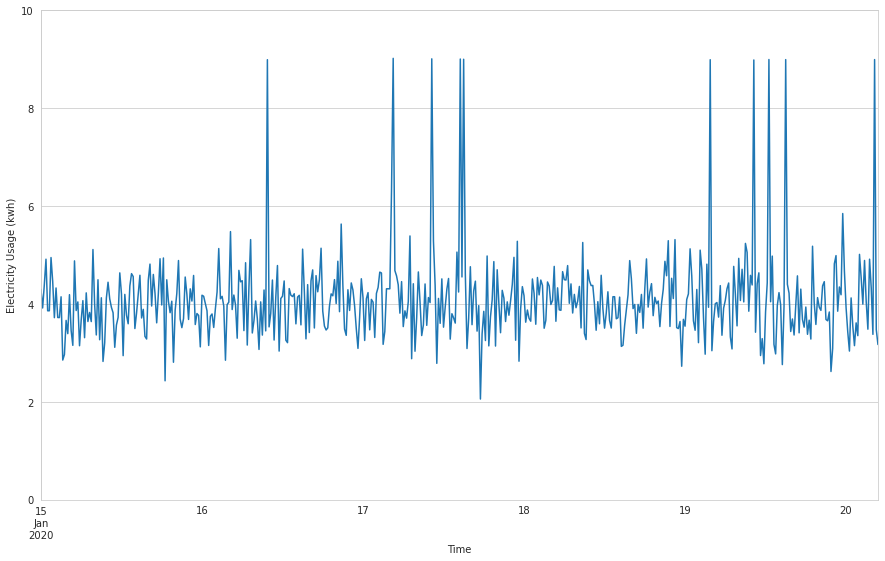

In [8]:
# Plot electricity usage
sensor_data.kwh.plot(
    figsize=(15, 9),
    ylim=(0, math.ceil(sensor_data.kwh.max())),
    xlabel='Time',
    ylabel='Electricity Usage (kwh)',
)

<AxesSubplot:>

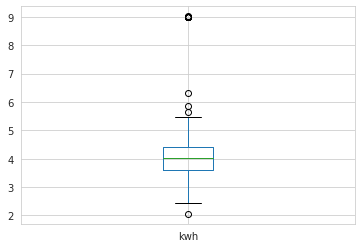

In [9]:
# Generate a box plot
sensor_data.kwh.plot.box()

In [10]:
# Reshape the time series into a column vector
kwh = sensor_data.kwh.values.reshape(-1, 1)

# Fit the isolation forest model
rng = np.random.RandomState(42)
isolation_forest_clf = IsolationForest(
    contamination=0.02,
    max_samples=100,
    random_state=rng
)
isolation_forest_clf.fit(kwh)
outlier_pred = isolation_forest_clf.predict(kwh)

In [11]:
# add outlier predictions as new df column
sensor_data['predicted_outlier'] = outlier_pred

In [12]:
sensor_data.predicted_outlier.value_counts()

 1    490
-1     10
Name: predicted_outlier, dtype: int64

In [13]:
sensor_data.loc[sensor_data.predicted_outlier == -1, ['kwh', 'predicted_outlier']]

,kwh,predicted_outlier
ts,,
2020-01-16 09:45:00,8.991691,-1
2020-01-17 04:30:00,9.019094,-1
2020-01-17 10:15:00,9.009262,-1
2020-01-17 14:30:00,9.005630,-1
2020-01-17 15:00:00,9.000485,-1
2020-01-19 03:45:00,8.991360,-1
2020-01-19 10:15:00,8.986014,-1
2020-01-19 12:30:00,8.995129,-1
2020-01-19 15:00:00,8.993494,-1


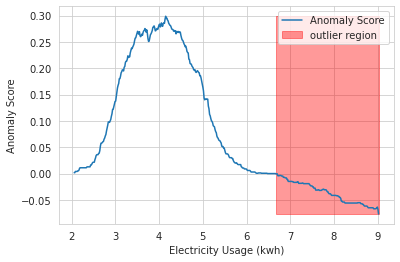

In [14]:
# Plot the anomaly score threshold and outlier region
xx = np.linspace(kwh.min(), kwh.max(), kwh.size).reshape(-1, 1)
anomaly_score = isolation_forest_clf.decision_function(xx)
outlier = isolation_forest_clf.predict(xx)

plt.plot(xx, anomaly_score, label='Anomaly Score')
plt.fill_between(
    xx.T[0],
    np.min(anomaly_score),
    np.max(anomaly_score),
    where=outlier==-1,
    color='r', 
    alpha=.4,
    label='outlier region'
)
plt.legend()
plt.ylabel('Anomaly Score')
plt.xlabel('Electricity Usage (kwh)')
plt.show();